# Reconocer dígitos en lenguaje de señas

La tarea tiene como objetivo reconocer dígitos en lenguaje de señas.

Hay un total de 10 preguntas que deben ser respondidas y celdas con código fuente que hay que completar. 

Tratar de alcanzar una precisión (accuracy) mayor a 0.90 en el dataset de test, lo recomendable es llegar a 0.95.

Utilizar JupyterHub o una instalación de Jupyter local (Anaconda3) para realizar la tarea.

In [599]:
# Importamos librerías.

import os
import numpy as np
from os import listdir
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.datasets import mnist
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import initializers
from sklearn.model_selection import train_test_split
from PIL import Image
import imageio

import matplotlib.pyplot as plt

Asignamos algunas configuraciones, dimension de las imágenes utilizar seteando `img_size` el cuál tendremos imágenes de `img_size`x`img_size`.  
Con `test_size` asignamos el porcentaje de imágenes para el dataset de testing.

In [600]:
img_size = 64
num_class = 10
test_size = 0.2

## Importamos dataset

Usaremos un dataset el cuál contiene 1650 imágenes con 10 categorías diferentes. Cada categoría es un dígito del 0 al 9 representado en lenguaje de señas. Cada imagen posee una resolución de 100x100 pixels y cada pixel ocupa 3 valores de color (RGB).

La siguiente celda carga las imágenes desde la carpeta 'sign_language_digits'. Para descomprimir un archivo zip en Jupyer se puede ejecutar la siguiente línea en una celda:

!unzip sign_language_digits.zip

In [601]:
def get_img(data_path):
    # Getting image array from path:
    img = Image.open(data_path)
    img = img.resize((img_size, img_size))
    return np.asarray(img)

def get_dataset(dataset_path='./sign_language_digits'):
    labels = listdir(dataset_path) # Geting labels
    X = []
    Y = []
    for i, label in enumerate(labels):
        datas_path = dataset_path+'/'+label
        for data in listdir(datas_path):
            img = get_img(datas_path+'/'+data)
            X.append(img)
            Y.append(int(label))
    X = np.array(X).astype('float32')/255.
    Y = np.array(Y).astype('int')
    X, X_test, Y, Y_test = train_test_split(X, Y, test_size=test_size)
    return X, X_test, Y, Y_test


Separamos el dataset de testing con el de entrenamiento

In [602]:
X, X_test, Y, Y_test = get_dataset()

Mostramos un ejemplo de imagen.

Etiqueta de la imagen: 8


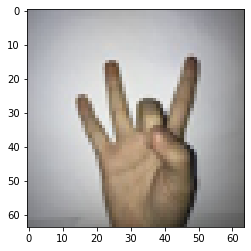

In [603]:
nro_imagen = 1

image = X[nro_imagen].reshape(1, img_size, img_size, 3)
plt.imshow(X[nro_imagen])
print("Etiqueta de la imagen: "+str(Y[nro_imagen]))

In [604]:
shape=image.shape
print (shape)
shape2 = X[nro_imagen].shape
print (shape2)

(1, 64, 64, 3)
(64, 64, 3)


Tenemos 4 vectores:

* `X` e `Y` son arrays del *training set*—los datos que usaremos para entrenar el modelo.
* El modelo será testeado con el *test set*, `X_test` e `Y_test` arrays.

Las imágenes son matrices de 64x64x3 (si seteamos img_size=64), cada componente de los 3 que tiene cada pixel toma valores reales entre 0 y 1. Los *labels* es un array de enteros en el rango de 0 a 9. Corresponden al dígito que representa la imagen.

## Exploración los datos

Antes de construir y entrenar un modelo debemos conocer los datos.

In [605]:
# Tamaño del dataset de entrenamiento.
X.shape

(1330, 64, 64, 3)

In [606]:
# Cantidad de labels de entrenamiento.
len(Y)

1330

In [607]:
# Cada label es un entero entre 0 y 9.
Y

array([0, 8, 2, ..., 7, 4, 3])

Completa las siguientes dos celdas para mostrar el tamaño del dataset de test.

In [608]:
# Tamaño del dataset de test

# TU CODIGO AQUI
X_test.shape


(333, 64, 64, 3)

In [609]:
# Cantidad de labels de test.

# TU CODIGO AQUI
len(Y_test)


333

## Construir el modelo

Para nuestra solución construiremos una red neuronal.

**PREGUNTAS**

**1) ¿Qué razones hay para utilizar redes neuronales en la resolución de este problema?**

Estamos frente a un problema de indentificar imágenes etiquetadas. Por lo tanto, resulta razonable utilizar redes neuronales que es un método de clasificación supervisado y se recomienda para trabajar con imágenes.

**2) ¿Qué cantidad de features (input) tendrá la red (considerar la variable img_size)?**

En este caso como entrada tenemos una imagen RGB de 64x64 pixels, por lo tanto, la red tendrá una cantidad de inputo featues de: 3*img_size*img_size (3*64*64).

**3) ¿Qué representa cada feature?**

Cada feature maps es un canal diferente de la imagen.
Cada canal se enfoca en aprender un patrón o característica, en este caso contenida en la imagen.


**4) La última capa de la red, ¿Cuántas neuronas deberá tener? ¿Por qué?**

La última capa deberá tener 10 neuronas, dado que las imágenes a clasificar representan a los dígitos del 0 al 9 (que son 10 diferentes).

**5) ¿Utilizarías una red convolucional? ¿Por qué?**

Si, al utulizar un red convolucional estamos obligando a la red a aprender a partir de una pequeña ventana (núcleo o kernel) la cual “movemos” sobre toda la imagen, realizando la convolución.
De esta manera aprenderá información relativa a los datos de la imagen, los pixels. Y evitamos que aprenda a partir de información relacionada a la dimensión o posición de la característica dentro de la imagen: esquina inferior, centro, arriba, abajo, etc.


### Construir las capas de la red

La unidad básica de construcción de una red neuronal en keras son las capas (layer). 



### Algunos tipos de capas que podemos usar

**Conv2D** (https://keras.io/layers/convolutional/)

Capa convolucional. Parámetros:

* *filters*: Cantidad de filtros o canales.

* *kernel_size*: Tamaño de la ventana que recorrerá la imagen. Ejemplos: (3,3), (5,5), (7,7).
* *input_shape*: La dimensión y tamaño de los datos de entrada. Es necesario definirla solamente en la primera capa de la red, en las otras será igual a la salida de la capa anterior. **Ejemplo:** si tenemos como entrada imágenes de 150x100x3 input_shape será (150,100,3).

* *padding*: Aumenta el tamaño de entrada con 0's, de esta manera podemos ajustar el tamaño del feature map generado aplicando el kernel. *padding* puede ser 'valid' el cuál no agregará nada o 'same' que agregará tantos ceros tal que el feature map generado sea del mismo tamaño que la entrada.

<img src="https://s3-us-west-2.amazonaws.com/static.pyimagesearch.com/keras-conv2d/keras_conv2d_padding.gif" width="500">

La red convolucional 2D espera de entrada imágenes donde cada pixel puede tener 1 o más valores (escala de grises, RGB). En nuestro caso será RGB.




**MaxPooling2D** (https://keras.io/layers/pooling/)

Capa de pooling, comúnmente usada luego de una capa convolucional. Selecciona y reduce la cantidad de valores. Parámetros:

* *pool_size*: Reduce el tamaño de entrada de forma: (vertical, horizontal). Ejemplo: (2,2)



**Flatten** (https://keras.io/layers/core/)

Redimensiona la estructura de la entrada y retorna un vector manteniendo los mismos valores.

Por ejemplo, luego de varias capas convolucionales y pooling tendremos varios canales (features maps) donde cada uno será una matriz dos dimensiones, se puede pensar como una estructura en 3 dimensiones. Para conectarla con una capa de neuronas densa (todas conectadas con todas) se debe redimensionar a un vector, se utiliza Flatten para conectar parte convolucional con capas densas.


**Dense** (https://keras.io/layers/core/)

Capa de neuronas, se conecta todas las entradas con todas las neuronas.

* *units*: Cantidad de neuronas de la capa.
* *activation*: Función de activación (https://keras.io/activations/), funciones comúnmente utilizadas: 'softmax', 'relu', 'sigmoid'.



***Bosquejo de una arquitectura con capas convolucionales, pooling y capas densas:***

<img src="https://missinglink.ai/wp-content/uploads/2019/07/A-Convolutional-Neural-Network.png" width="800">

In [610]:
# Se da un diseño inicial de la red neuronal.
# A las capas dadas les falta setear algunas configuraciones (se muestra con ...)

# Es posible utilizar una activación para la salida (última capa) y otra activación diferente
# para las capas internas, probar con la activación relu para las capas internas.


model = Sequential()
kernel = (5, 5)
#model.add(Conv2D(filters=16, kernel_size=..., padding='same', input_shape=...))
model.add(Conv2D(filters=16, kernel_size=kernel, padding='same', input_shape=shape2))
#model.add(Activation(...))
model.add(Activation("relu"))
#model.add(MaxPooling2D(pool_size=...))
model.add(MaxPooling2D(pool_size=(2, 2)))


# Agregar aquí más capas convolucionales.
# Capa2
model.add(Conv2D(filters=32, kernel_size=kernel, activation="relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Capa3
model.add(Conv2D(filters=64, kernel_size=kernel, activation="relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))

    
model.add(Flatten())

model.add(Dropout(0.3))
    
# Agregar más capas densas.
# Primer capa densa de neuronas
model.add(Dense(512, activation="relu"))

model.add(Dropout(0.3))

# Segunda capa densa de neuronas
model.add(Dense(1024, activation="relu"))



# Ultima capa o capa de salida
#model.add(Dense(units=...))
model.add(Dense(units=num_class))
model.add(Activation("softmax"))


### Compilar el modelo

Antes de comenzar a entrenar el modelo hay que setear algunas configuraciones extras. Se setean durante el paso de *compilación*:

* *Loss function* —Mide cuál es el error del modelo durante el entrenamiento. El objetivo es minimizar esta función.
* *Optimizer* —Es cómo se actualizará los parámetros del modelo para minimizar la función de pérdida (loss function).
* *Metrics* —Para monitorizar la etapa de entrenamiento. Usaremos *accuracy*, la fracción de las imágenes que son correctamente clasificadas.

In [611]:
# Con sparse_categorical_crossentropy no es necesario aplicar one-hot-encoding.
# Podemos utilizar los labels directamente como enteros.

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [612]:
# Mostramos un resumen de la red neuronal.

print(model.summary())

Model: "sequential_84"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_249 (Conv2D)          (None, 64, 64, 16)        1216      
_________________________________________________________________
activation_161 (Activation)  (None, 64, 64, 16)        0         
_________________________________________________________________
max_pooling2d_246 (MaxPoolin (None, 32, 32, 16)        0         
_________________________________________________________________
conv2d_250 (Conv2D)          (None, 28, 28, 32)        12832     
_________________________________________________________________
max_pooling2d_247 (MaxPoolin (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_251 (Conv2D)          (None, 10, 10, 64)        51264     
_________________________________________________________________
max_pooling2d_248 (MaxPoolin (None, 5, 5, 64)        

## Entrenamos el modelo

Para entrenar el modelo utilizamos la función *fit*, esto hará que el modelo se ajuste a los datos de entrenamiento:

In [613]:
# Podrás modificar epochs y batch_size para obtener un mejor resultado o rendimiento.
history = model.fit(X, Y, validation_data=(X_test, Y_test), epochs=15, batch_size=32)

Epoch 1/15
42/42 [==============================] - 14s 345ms/step - loss: 2.3022 - accuracy: 0.1038 - val_loss: 2.2355 - val_accuracy: 0.0961
Epoch 2/15
42/42 [==============================] - 14s 337ms/step - loss: 1.5878 - accuracy: 0.4346 - val_loss: 0.8331 - val_accuracy: 0.6847
Epoch 3/15
42/42 [==============================] - 13s 319ms/step - loss: 0.8270 - accuracy: 0.7150 - val_loss: 0.5445 - val_accuracy: 0.8168
Epoch 4/15
42/42 [==============================] - 13s 319ms/step - loss: 0.5541 - accuracy: 0.8075 - val_loss: 0.3591 - val_accuracy: 0.8679
Epoch 5/15
42/42 [==============================] - 14s 324ms/step - loss: 0.4275 - accuracy: 0.8647 - val_loss: 0.2951 - val_accuracy: 0.8979
Epoch 6/15
42/42 [==============================] - 14s 325ms/step - loss: 0.2782 - accuracy: 0.9165 - val_loss: 0.2256 - val_accuracy: 0.9279
Epoch 7/15
42/42 [==============================] - 14s 331ms/step - loss: 0.1914 - accuracy: 0.9398 - val_loss: 0.1959 - val_accuracy: 0.9339

**PREGUNTAS**

**6) ¿Qué es el overfitting?**

Se denomina sobreajuste (overfitting) al hecho de hacer un modelo tan ajustado a los datos de entrenamiento que no generalice bien a los datos de test.


**7) ¿Por qué lo queremos evitar?**

Queremos evitarlo porque el objetivo es lograr una solución que generalice y logre buenos resultados frente a nuevos datos no conocidos y no solo frente a los datos de entrenamiento.


## Evaluar el modelo

Evaluamos el modelo con el dataset de train y test, luego graficamos la evolución del error y la precisión:

In [614]:
train_loss, train_acc = model.evaluate(X, Y)
test_loss, test_acc = model.evaluate(X_test, Y_test)

print('\nTrain accuracy:', train_acc)
print('\nTest accuracy:', test_acc)

11/11 [==============================] - 1s 62ms/step - loss: 0.1124 - accuracy: 0.9730

Train accuracy: 0.995488703250885

Test accuracy: 0.9729729890823364


**PREGUNTA**

**8) ¿Por qué el accuracy de test es menor al de train?**

El lógico que así sea dado que los datos de test (validación) son evaluados con los ajustes realizados con los datos de train (entrenamiento).


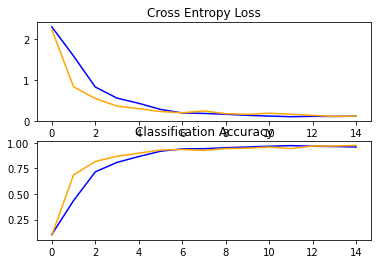

In [615]:
# Color azul: Entrenamiento.
# Color naranja: Testing.

from matplotlib import pyplot

# plot loss
pyplot.subplot(211)
pyplot.title('Cross Entropy Loss')
pyplot.plot(history.history['loss'], color='blue', label='train')
pyplot.plot(history.history['val_loss'], color='orange', label='test')

# plot accuracy
pyplot.subplot(212)
pyplot.title('Classification Accuracy')
# Nota: Si 'acc' da error probar con 'accuracy'
pyplot.plot(history.history['accuracy'], color='blue', label='train')
pyplot.plot(history.history['val_accuracy'], color='orange', label='test')

pyplot.show()

**PREGUNTA**

**9) En la gráfica, si la brecha entre ambos accuracy (training y test) es muy grande ¿Qué puede estar sucediendo?**

Se podría estar sucediendo un caso de sobreajuste (overfitting), ó un caso de subajuste (underfitting).
Si nuestros datos de entrenamiento son muy pocos sistema de aprendizaje automático no será capaz de generalizar el conocimiento y estará incurriendo en underfitting. El algoritmo no dará buenos resultados por falta de buenos ejemplos que le permitan reconocer características genéricas durante el entrenamiento. También es ejemplo de subajuste cuando el sistema reconoce por ejemplo todo animal de 4 patas peludo como un perro.
El caso del sobreajuste se produce cuando un sistema de aprendizaje automático se entrena demasiado o con datos anómalos, que hace que el algoritmo aprenda patrones que no son generales. Aprende características específicas pero no los patrones generales.

## Haciendo predicciones

Con el modelo entrenado podemos hacer predicciones sobre algunas imágenes.

In [616]:
predictions = model.predict(X_test)

Podemos ver qué predice nuestro modelo para la primera imagen:

In [617]:
predictions[0]

array([1.8201104e-03, 9.7547513e-01, 2.0927065e-03, 2.0466922e-02,
       3.9450097e-08, 9.7499495e-08, 1.0914544e-06, 1.2244951e-04,
       8.7641874e-06, 1.2595366e-05], dtype=float32)

**PREGUNTA**

**10) ¿Qué representa el vector *predictions*?**

Es el vector con las salidas que predice nuestro modelo para un conjunto dado de imágenes. En nuestro caso para cada imagen tenemos un vector con 10 valores de predicción que corresponden a cada dígito. La posición del valor más cercano a 1 indicará el dígito que predice nuestro modelo para la imagen correspondiente.


Vemos qué clase predice y cuál es la clase correcta para la primera imagen:

In [618]:
np.argmax(predictions[0])

1

In [619]:
Y_test[0]

1

In [620]:
np.argmax(predictions[20])

0

In [621]:
Y_test[20]

0

In [622]:
np.argmax(predictions[332])

7

In [623]:
Y_test[332]

7

In [624]:
np.argmax(predictions[166])

5

In [625]:
Y_test[166]

5